In [3]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from typing import List, Tuple

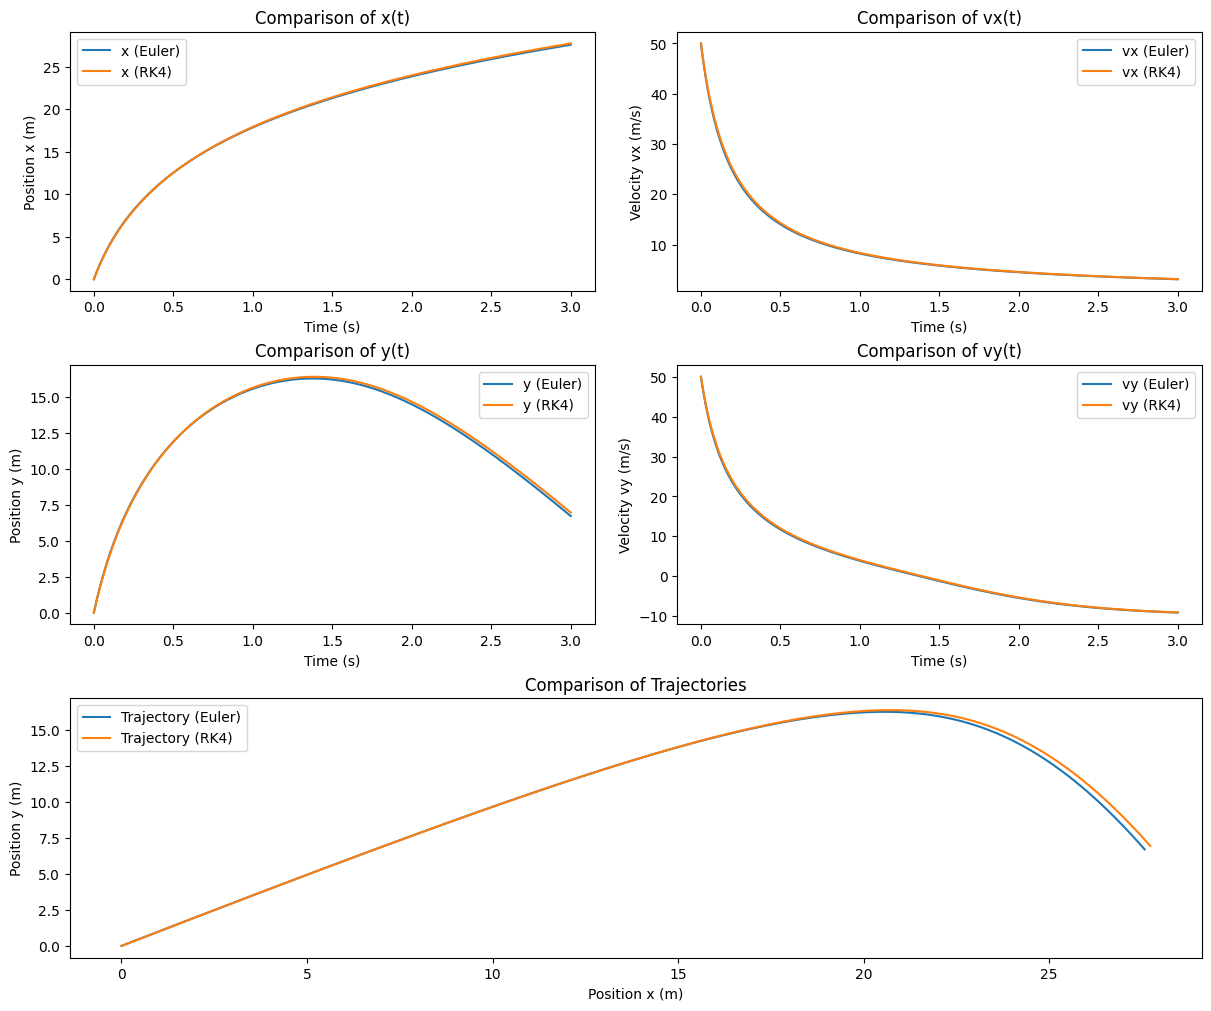

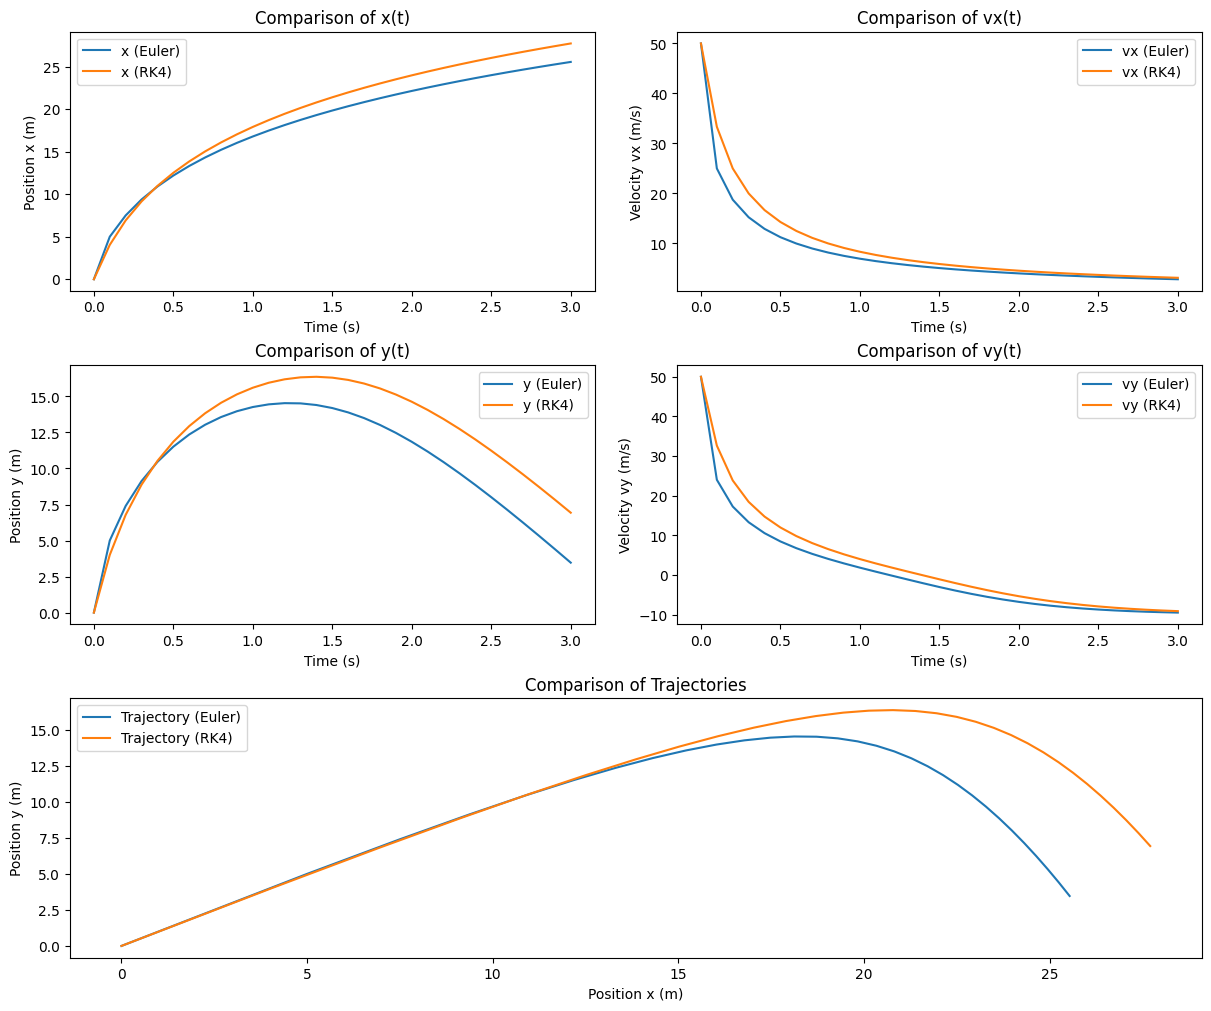

In [4]:
# -------------------------------------------------------------------------
# Execution examples:
# python exercise2.py --method rk4 --x0 0 --y0 0 --vx0 50 --vy0 50 --drag 0.1 --dt 0.01 --tfinal 3 --mass 1.0 --gravity 9.81
# python exercise2.py --method euler --x0 0 --y0 0 --vx0 50 --vy0 50 --drag 0.1 --dt 0.01 --tfinal 3 --mass 1.0 --gravity 9.81
# python exercise2.py --compare --x0 0 --y0 0 --vx0 50 --vy0 50 --drag 0.1 --dt 0.01 --tfinal 3 --mass 1.0 --gravity 9.81
# -------------------------------------------------------------------------


class Simulation:
    """
    Class to simulate the projectile motion under air resistance using numerical integration.

    Attributes:
        x0 (float): Initial x position.
        y0 (float): Initial y position.
        vx0 (float): Initial x velocity.
        vy0 (float): Initial y velocity.
        dt (float): Time step.
        t_final (float): Final simulation time.
        mass (float): Mass of the projectile.
        gravity (float): Gravitational acceleration.
        drag (float): Air resistance coefficient.
    """

    def __init__(
        self,
        x0: float,
        y0: float,
        vx0: float,
        vy0: float,
        dt: float,
        t_final: float,
        mass: float,
        gravity: float,
        drag: float,
    ) -> None:
        self.x0: float = x0
        self.y0: float = y0
        self.vx0: float = vx0
        self.vy0: float = vy0
        self.dt: float = dt
        self.t_final: float = t_final
        self.mass: float = mass
        self.gravity: float = gravity
        self.drag: float = drag
        self.initialize()

    def initialize(self) -> None:
        """Reset the simulation state to the initial conditions."""
        self.x: float = self.x0
        self.y: float = self.y0
        self.vx: float = self.vx0
        self.vy: float = self.vy0
        self.t: float = 0.0

        self.t_history: List[float] = [self.t]
        self.x_history: List[float] = [self.x]
        self.y_history: List[float] = [self.y]
        self.vx_history: List[float] = [self.vx]
        self.vy_history: List[float] = [self.vy]

    def observe(self) -> None:
        """
        Record the current state of the simulation and increment time by dt.
        """
        self.t += self.dt
        self.t_history.append(self.t)
        self.x_history.append(self.x)
        self.y_history.append(self.y)
        self.vx_history.append(self.vx)
        self.vy_history.append(self.vy)

    def update_euler(self) -> None:
        """
        Update the simulation state using the Euler integration method.
        """
        ax: float = -(self.drag / self.mass) * self.vx * abs(self.vx)
        ay: float = -self.gravity - (self.drag / self.mass) * self.vy * abs(self.vy)
        self.x += self.dt * self.vx
        self.vx += self.dt * ax
        self.y += self.dt * self.vy
        self.vy += self.dt * ay

    def update_rk4(self) -> None:
        """
        Update the simulation state using the fourth-order Runge-Kutta (RK4) method.
        """
        state: np.ndarray = np.array([self.x, self.y, self.vx, self.vy])

        def f(state: np.ndarray) -> np.ndarray:
            """
            Compute the derivatives of the state.

            Args:
                state (np.ndarray): Array containing [x, y, vx, vy].

            Returns:
                np.ndarray: Derivatives [vx, vy, ax, ay].
            """
            x, y, vx, vy = state
            ax: float = -(self.drag / self.mass) * vx * abs(vx)
            ay: float = -self.gravity - (self.drag / self.mass) * vy * abs(vy)
            return np.array([vx, vy, ax, ay])

        dt: float = self.dt
        k1: np.ndarray = f(state)
        k2: np.ndarray = f(state + 0.5 * dt * k1)
        k3: np.ndarray = f(state + 0.5 * dt * k2)
        k4: np.ndarray = f(state + dt * k3)
        state_next: np.ndarray = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        self.x, self.y, self.vx, self.vy = state_next

    def run_simulation(
        self, method: str
    ) -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
        """
        Run the simulation using the specified integration method.

        Args:
            method (str): Integration method ('euler' or 'rk4').

        Returns:
            Tuple containing histories: time, x, y, vx, and vy.
        """
        self.initialize()
        num_steps: int = int(self.t_final / self.dt)

        for _ in range(num_steps):
            if method.lower() == "euler":
                self.update_euler()
            elif method.lower() == "rk4":
                self.update_rk4()
            else:
                raise ValueError(f"Unknown method: {method}")
            self.observe()

        return (
            self.t_history,
            self.x_history,
            self.y_history,
            self.vx_history,
            self.vy_history,
        )


def generate_comparison_plots(
    t_euler: List[float],
    x_euler: List[float],
    y_euler: List[float],
    vx_euler: List[float],
    vy_euler: List[float],
    t_rk4: List[float],
    x_rk4: List[float],
    y_rk4: List[float],
    vx_rk4: List[float],
    vy_rk4: List[float],
) -> None:
    """
    Generate plots to compare the Euler and RK4 integration methods.

    Args:
        t_euler, x_euler, y_euler, vx_euler, vy_euler (List[float]): Histories from Euler method.
        t_rk4, x_rk4, y_rk4, vx_rk4, vy_rk4 (List[float]): Histories from RK4 method.
    """
    fig = plt.figure(constrained_layout=True, figsize=(12, 10))
    gs = fig.add_gridspec(3, 2)

    # Plot for x(t)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t_euler, x_euler, label="x (Euler)")
    ax1.plot(t_rk4, x_rk4, label="x (RK4)")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Position x (m)")
    ax1.set_title("Comparison of x(t)")
    ax1.legend()

    # Plot for vx(t)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t_euler, vx_euler, label="vx (Euler)")
    ax2.plot(t_rk4, vx_rk4, label="vx (RK4)")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Velocity vx (m/s)")
    ax2.set_title("Comparison of vx(t)")
    ax2.legend()

    # Plot for y(t)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(t_euler, y_euler, label="y (Euler)")
    ax3.plot(t_rk4, y_rk4, label="y (RK4)")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Position y (m)")
    ax3.set_title("Comparison of y(t)")
    ax3.legend()

    # Plot for vy(t)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(t_euler, vy_euler, label="vy (Euler)")
    ax4.plot(t_rk4, vy_rk4, label="vy (RK4)")
    ax4.set_xlabel("Time (s)")
    ax4.set_ylabel("Velocity vy (m/s)")
    ax4.set_title("Comparison of vy(t)")
    ax4.legend()

    # Trajectory plot
    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(x_euler, y_euler, label="Trajectory (Euler)")
    ax5.plot(x_rk4, y_rk4, label="Trajectory (RK4)")
    ax5.set_xlabel("Position x (m)")
    ax5.set_ylabel("Position y (m)")
    ax5.set_title("Comparison of Trajectories")
    ax5.legend()

    plt.show()

def main() -> None:
    x0 = 0
    y0 = 0
    vx0 = 50
    vy0 = 50
    drag = 0.1
    dt = 0.01
    tfinal = 3
    mass = 1.0
    gravity = 9.81

    for dt in [0.01, 0.1]:
      sim = Simulation(
          x0,
          y0,
          vx0,
          vy0,
          dt,
          tfinal,
          mass,
          gravity,
          drag,
      )

      t_euler, x_euler, y_euler, vx_euler, vy_euler = sim.run_simulation("euler")
      t_rk4, x_rk4, y_rk4, vx_rk4, vy_rk4 = sim.run_simulation("rk4")
      generate_comparison_plots(
          t_euler,
          x_euler,
          y_euler,
          vx_euler,
          vy_euler,
          t_rk4,
          x_rk4,
          y_rk4,
          vx_rk4,
          vy_rk4,
      )


if __name__ == "__main__":
    main()
